In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# !pip install azure-cognitiveservices-search-imagesearch

In [51]:
import os
import requests
from pathlib import Path

from fastai.vision.all import *
from fastai.vision.widgets import *

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

In [13]:
key = os.environ.get('AZURE_SEARCH_KEY')

In [25]:
def search_images_bing(key, term, min_sz=128, max_images=150):    
    params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()    
    # L is a fastai method
    return L(search_results['value'])

In [26]:
results = search_images_bing(key, 'grizzly bear', max_images=1)

In [27]:
imgs = results.attrgot('contentUrl')

In [28]:
dest = Path('../images/grizzly.jpg')
download_url(imgs[0], dest)

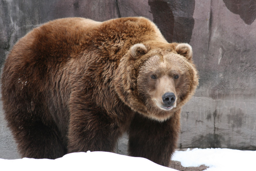

In [29]:
im= Image.open(dest)
im.to_thumb(256,256)

In [32]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [33]:
if not path.exists():
    path.mkdir()
    for bear in bear_types:
        dest = (path/bear)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{bear} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://www.myflowergift.com/media/catalog/product/cache/1/image/1200x1200/9df78eab33525d08d6e5fb8d27136e95/8/_/8_pink_roses_bunch_with_pink_paper_n_12_inch_pink_teddy_rs_1045.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p bears/teddy
$ cd bears/teddy
$ wget -c https://www.myflowergift.com/media/catalog/product/cache/1/image/1200x1200/9df78eab33525d08d6e5fb8d27136e95/8/_/8_pink_roses_bunch_with_pink_paper_n_12_inch_pink_teddy_rs_1045.jpg
$ tar xf 8_pink_roses_bunch_with_pink_paper_n_12_inch_pink_teddy_rs_1045.jpg
 And re-run your code once the download is successful



In [34]:
fns = get_image_files(path)
fns

(#420) [Path('bears/grizzly/00000111.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000073.jpg'),Path('bears/grizzly/00000071.jpg'),Path('bears/grizzly/00000051.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000131.jpg'),Path('bears/grizzly/00000041.jpg')...]

In [35]:
failed = verify_images(fns)
failed

(#5) [Path('bears/grizzly/00000091.jpg'),Path('bears/grizzly/00000027.jpg'),Path('bears/teddy/00000092.jpg'),Path('bears/teddy/00000125.jpg'),Path('bears/teddy/00000069.jpg')]

In [36]:
failed.map(Path.unlink);

In [37]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [38]:
bears

In [40]:
dls = bears.dataloaders(path)

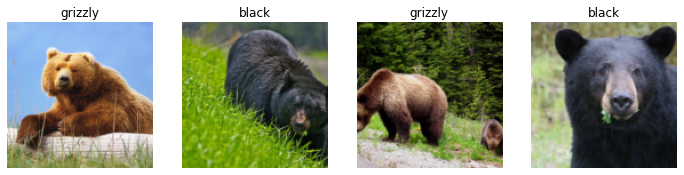

In [41]:
dls.valid.show_batch(max_n=4, nrows=1)

### Transform Squish

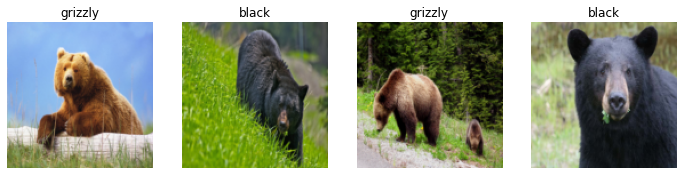

In [42]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Transform Pad

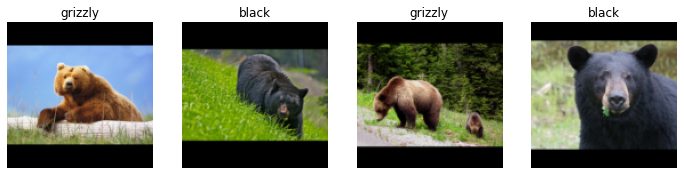

In [43]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### RandomResizedCrop (Simple Data Augmentation)

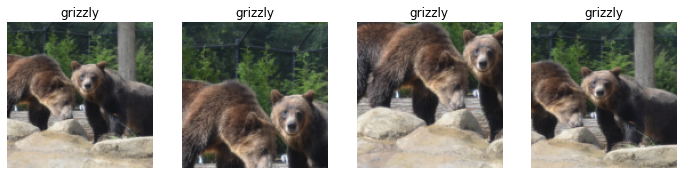

In [44]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

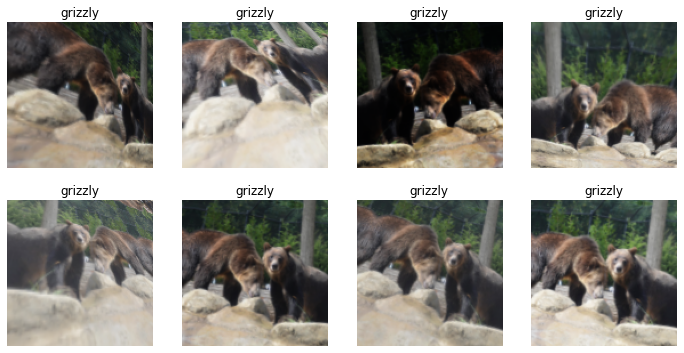

In [45]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Train

In [46]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [47]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/mihlos/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.043075,0.054977,0.012048,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.156823,0.060503,0.012048,00:07
1,0.134809,0.086231,0.024096,00:06
2,0.097707,0.095669,0.012048,00:06
3,0.083622,0.094843,0.012048,00:06
4,0.068948,0.104728,0.024096,00:07


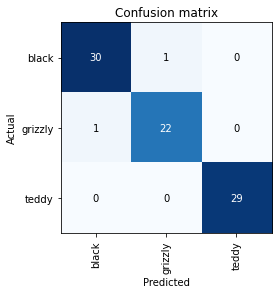

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

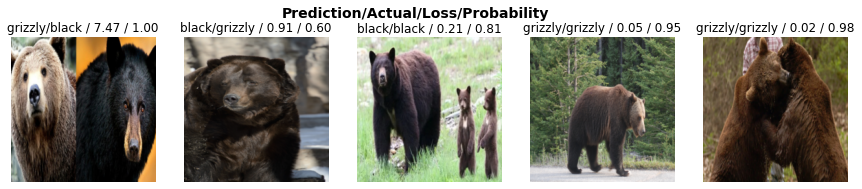

In [49]:
interp.plot_top_losses(5, nrows=1)

In [52]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [53]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

### Re-Train

In [57]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [58]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.008554,0.087132,0.024390,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.135106,0.048652,0.012195,00:06
1,0.096147,0.049622,0.024390,00:07
2,0.067168,0.064548,0.024390,00:06
3,0.059722,0.089967,0.024390,00:07
4,0.052682,0.096717,0.024390,00:07


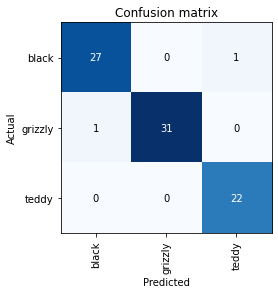

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

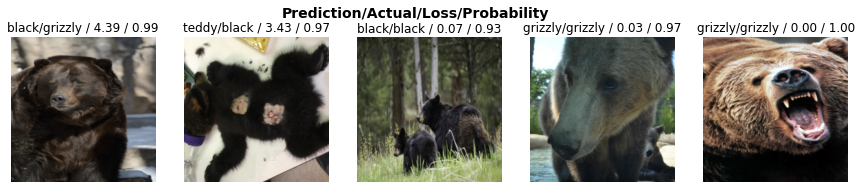

In [60]:
interp.plot_top_losses(5, nrows=1)

### Inference

In [61]:
learn.export()

In [62]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [63]:
learn_inf = load_learner(path/'export.pkl')

In [64]:
learn_inf.predict('../images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.1398e-06, 1.0000e+00, 4.2125e-07]))

In [65]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']